In [39]:
import pickle
import pandas as pd
import seaborn as sns
from os.path import exists
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import joblib

# Load Data

In [40]:
series_matrix = pd.read_csv('data/GSE68086_series_matrix.csv')
print(series_matrix.shape)
print(series_matrix.head())

(285, 46)
  !Sample_geo_accession           !Sample_status !Sample_submission_date  \
0          "GSM1662534"  "Public on Oct 30 2015"           "Apr 21 2015"   
1          "GSM1662535"  "Public on Oct 30 2015"           "Apr 21 2015"   
2          "GSM1662536"  "Public on Oct 30 2015"           "Apr 21 2015"   
3          "GSM1662537"  "Public on Oct 30 2015"           "Apr 21 2015"   
4          "GSM1662538"  "Public on Oct 30 2015"           "Apr 21 2015"   

  !Sample_last_update_date !Sample_type !Sample_channel_count  \
0            "May 15 2019"        "SRA"                   "1"   
1            "May 15 2019"        "SRA"                   "1"   
2            "May 15 2019"        "SRA"                   "1"   
3            "May 15 2019"        "SRA"                   "1"   
4            "May 15 2019"        "SRA"                   "1"   

  !Sample_source_name_ch1 !Sample_organism_ch1 !Sample_characteristics_ch1  \
0    "3-Breast-Her2-ampl"       "Homo sapiens"             "tiss

In [41]:
TEP_data = pd.read_csv('data/GSE68086_TEP_data_matrix.csv')
print(TEP_data.shape)
print(TEP_data.head())

(57736, 286)
        Unnamed: 0  3-Breast-Her2-ampl  8-Breast-WT  10-Breast-Her2-ampl  \
0  ENSG00000000003                   0            0                    0   
1  ENSG00000000005                   0            0                    0   
2  ENSG00000000419                  44           14                   16   
3  ENSG00000000457                  26            1                   14   
4  ENSG00000000460                  81           98                   18   

   Breast-100  15-Breast-Her2-ampl  16-Breast-WT  21-Breast-WT  \
0           0                   17             0             0   
1           0                    0             0             0   
2           8                    9             0           139   
3           0                    4            20             1   
4          17                    0            20           144   

   33-Breast-Her2-ampl  42-Breast-Her2-ampl  ...  MGH-NSCLC-L20-TR500  \
0                    0                    0  ...            

# Clean Data

In [42]:
# Keep only the sample source and cancer type columns
series_matrix_source_cancer = series_matrix[['!Sample_source_name_ch1', '!Sample_characteristics_ch1.3']]
# Rename the columns
series_matrix_source_cancer.columns = ['Sample', 'Cancer_Type']
# Delete the double quotes in the source
series_matrix_source_cancer['Sample'] = series_matrix_source_cancer['Sample'].str.replace('"', '')
# Delete the cancer type in str
series_matrix_source_cancer['Cancer_Type'] = series_matrix_source_cancer['Cancer_Type'].str.replace('cancer type: ', '')
series_matrix_source_cancer['Cancer_Type'] = series_matrix_source_cancer['Cancer_Type'].str.replace('"', '')
# One hot encode the cancer type
series_matrix_source_cancer = pd.get_dummies(series_matrix_source_cancer, columns=['Cancer_Type'])
print(series_matrix_source_cancer.head())

# Write the data to a csv file
series_matrix_source_cancer.to_csv('data/series_matrix_source_cancer.csv', index=False)

                Sample  Cancer_Type_Breast  Cancer_Type_CRC  Cancer_Type_GBM  \
0   3-Breast-Her2-ampl                True            False            False   
1          8-Breast-WT                True            False            False   
2  10-Breast-Her2-ampl                True            False            False   
3           Breast-100                True            False            False   
4  15-Breast-Her2-ampl                True            False            False   

   Cancer_Type_HC  Cancer_Type_Hepatobiliary  Cancer_Type_Lung  \
0           False                      False             False   
1           False                      False             False   
2           False                      False             False   
3           False                      False             False   
4           False                      False             False   

   Cancer_Type_Pancreas  Cancer_Type_mutational subclass: EGFR  \
0                 False                                 

/var/folders/12/sgrgj1zj27g2_6chndcqh8740000gn/T/ipykernel_70592/698329259.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  series_matrix_source_cancer['Sample'] = series_matrix_source_cancer['Sample'].str.replace('"', '')
/var/folders/12/sgrgj1zj27g2_6chndcqh8740000gn/T/ipykernel_70592/698329259.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  series_matrix_source_cancer['Cancer_Type'] = series_matrix_source_cancer['Cancer_Type'].str.replace('cancer type: ', '')
/var/folders/12/sgrgj1zj27g2_6chndcqh8

In [43]:
# Load the data
patient_data = pd.read_csv('data/series_matrix_source_cancer.csv')
rna_expression = pd.read_csv('data/GSE68086_TEP_data_matrix.csv', index_col=0)
# print(patient_data.head())

# Reset the index to make the index a regular column
rna_expression.reset_index(inplace=True)
# Rename the index column to 'gene_ID'
rna_expression.rename(columns={'index': 'gene_ID'}, inplace=True)

# Reshape data from wide to long format
rna_expression_long = rna_expression.melt(id_vars=['gene_ID'], var_name='Sample', value_name='FPKM')

# print(rna_expression_long.head())

# Merge the patient data with the rna expression data
patient_data['Sample'] = patient_data['Sample']
merged_data = pd.merge(rna_expression_long, patient_data, on='Sample')
print(merged_data.head())

# Write the data to a csv file
merged_data.to_csv('data/merged_data.csv', index=False)


           gene_ID              Sample  FPKM  Cancer_Type_Breast  \
0  ENSG00000000003  3-Breast-Her2-ampl     0                True   
1  ENSG00000000005  3-Breast-Her2-ampl     0                True   
2  ENSG00000000419  3-Breast-Her2-ampl    44                True   
3  ENSG00000000457  3-Breast-Her2-ampl    26                True   
4  ENSG00000000460  3-Breast-Her2-ampl    81                True   

   Cancer_Type_CRC  Cancer_Type_GBM  Cancer_Type_HC  \
0            False            False           False   
1            False            False           False   
2            False            False           False   
3            False            False           False   
4            False            False           False   

   Cancer_Type_Hepatobiliary  Cancer_Type_Lung  Cancer_Type_Pancreas  \
0                      False             False                 False   
1                      False             False                 False   
2                      False             Fal

# Visualize Data

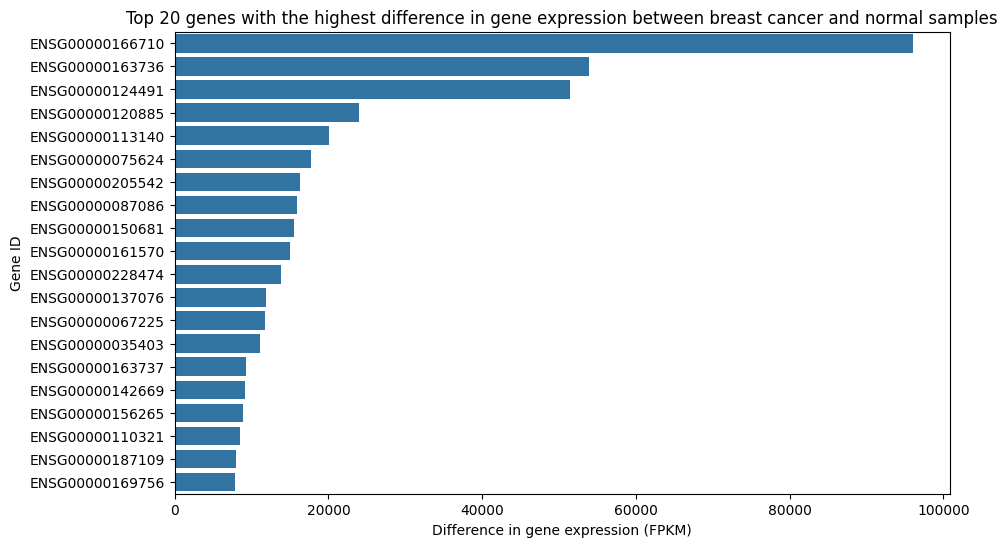

In [44]:
merged_data = pd.read_csv('data/merged_data.csv')
# Compare the difference in gene expression between breast cancer and normal samples
# Select the breast cancer and normal samples
breast_cancer_patients = merged_data[(merged_data['Cancer_Type_Breast'] == 1)]
healthy_controls = merged_data[(merged_data['Cancer_Type_HC'] == 1)]

# Calculate the mean gene expression for each gene in breast cancer and normal samples
breast_cancer_mean_expression = breast_cancer_patients.groupby('gene_ID')['FPKM'].mean()
healthy_controls_mean_expression = healthy_controls.groupby('gene_ID')['FPKM'].mean()

# Calculate the difference in gene expression between breast cancer and normal samples
gene_expression_difference = breast_cancer_mean_expression - healthy_controls_mean_expression
# Sort the genes based on the difference in gene expression
gene_expression_difference = gene_expression_difference.sort_values(ascending=False)

# Plot the 20 genes with the highest difference in gene expression
plt.figure(figsize=(10, 6))
sns.barplot(x=gene_expression_difference.head(20).values, y=gene_expression_difference.head(20).index)
plt.xlabel('Difference in gene expression (FPKM)')
plt.ylabel('Gene ID')
plt.title('Top 20 genes with the highest difference in gene expression between breast cancer and normal samples')
plt.show()




# Prepare data for Random Forest Model

In [45]:
# Use only a subset of genes with highest expression differences for simplicity
top_genes = gene_expression_difference.head(20).index
model_data = merged_data[merged_data['gene_ID'].isin(top_genes)]
model_data = model_data.pivot(index='Sample', columns='gene_ID', values='FPKM').reset_index()
model_data = model_data.merge(patient_data, on='Sample')
X = model_data[top_genes]
y = model_data['Cancer_Type_Breast']  # Binary target: Breast cancer vs. healthy control

# Standardize the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest Model

In [46]:
# Define parameter grid for RandomizedSearchCV
param_dist = {
    'n_estimators': [50, 100, 200, 500],
    'max_depth': [None, 10, 20, 30, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Initialize the Random Forest model
rf_model = RandomForestClassifier(random_state=42)

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=rf_model, param_distributions=param_dist,
                                   n_iter=20, cv=5, random_state=42, n_jobs=-1)
# Fit the RandomizedSearchCV
random_search.fit(X_train, y_train)

# Use the best estimator found by RandomizedSearchCV
best_rf_model = random_search.best_estimator_

print('Best Random Forest model:' + str(best_rf_model))
print('Best Score: ' + str(random_search.best_score_))

Best Random Forest model:RandomForestClassifier(max_depth=10, min_samples_leaf=2, min_samples_split=10,
                       n_estimators=50, random_state=42)
Best Score: 0.9168115942028985


# Predict and Evaluate Model, Classification Report

In [47]:
y_pred = best_rf_model.predict(X_test)
print("Classification Report for Random Forest Model")
print(classification_report(y_test, y_pred))

Classification Report for Random Forest Model
              precision    recall  f1-score   support

       False       0.95      1.00      0.97        54
        True       0.00      0.00      0.00         3

    accuracy                           0.95        57
   macro avg       0.47      0.50      0.49        57
weighted avg       0.90      0.95      0.92        57



/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

# Classification Report Heatmap

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

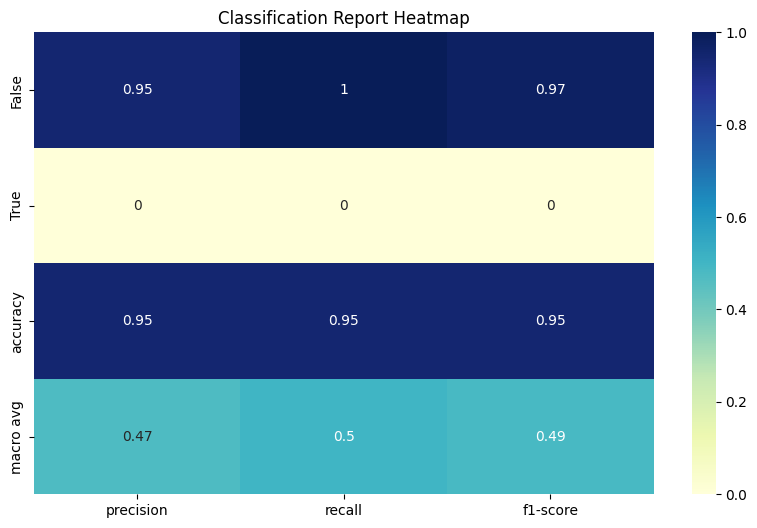

In [48]:
report = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose()
plt.figure(figsize=(10, 6		))
sns.heatmap(report_df.iloc[:-1, :-1], annot=True, cmap='YlGnBu')
plt.title('Classification Report Heatmap')
plt.show()

# Confusion Matrix

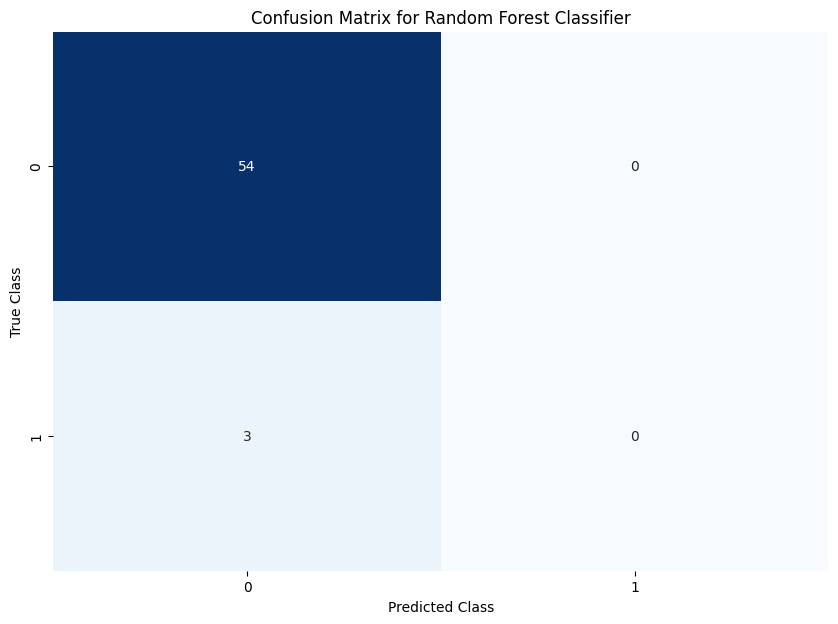

In [49]:
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Confusion Matrix for Random Forest Classifier")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.show()

